In [1]:
	
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
data=pd.read_csv("Retail_Prices_of _Products.csv")
data.head(5)

,Year,Month,GEO,Product Category,Products,VALUE,Taxable,Total tax rate,Value after tax,Essential,COORDINATE,UOM
0,2017,January,Province 1,Meat & Poultry,"Beef stewing cuts, per kilogram",12.66,No,11.0,12.66,Essential,11.10,Dollars
1,2017,January,Province 1,Meat & Poultry,"Beef striploin cuts, per kilogram",21.94,No,11.0,21.94,Essential,11.20,Dollars
2,2017,January,Province 1,Meat & Poultry,"Beef top sirloin cuts, per kilogram",13.44,No,11.0,13.44,Essential,11.30,Dollars
3,2017,January,Province 1,Meat & Poultry,"Beef rib cuts, per kilogram",20.17,No,11.0,20.17,Essential,11.41,Dollars
4,2017,January,Province 1,Meat & Poultry,"Ground beef, per kilogram",9.12,No,11.0,9.12,Essential,11.40,Dollars


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118482 entries, 0 to 118481
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Year              118482 non-null  int64  
 1   Month             118482 non-null  object 
 2   GEO               118482 non-null  object 
 3   Product Category  118482 non-null  object 
 4   Products          118482 non-null  object 
 5   VALUE             118482 non-null  float64
 6   Taxable           118482 non-null  object 
 7   Total tax rate    118482 non-null  float64
 8   Value after tax   118482 non-null  float64
 9   Essential         118482 non-null  object 
 10  COORDINATE        118482 non-null  float64
 11  UOM               118482 non-null  object 
dtypes: float64(4), int64(1), object(7)
memory usage: 10.8+ MB


In [4]:
data.isnull().sum()

Year                0
Month               0
GEO                 0
Product Category    0
Products            0
VALUE               0
Taxable             0
Total tax rate      0
Value after tax     0
Essential           0
COORDINATE          0
UOM                 0
dtype: int64

In [5]:
data.duplicated().sum()

0

Text(0.5, 1.0, 'Distribution of Product Values')

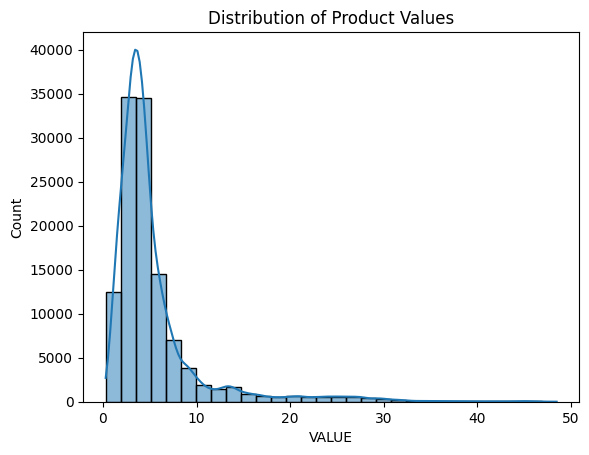

In [6]:
sns.histplot(data['VALUE'], bins=30, kde=True)
plt.title('Distribution of Product Values')

Text(0.5, 1.0, 'Top 10 Most Expensive Products')

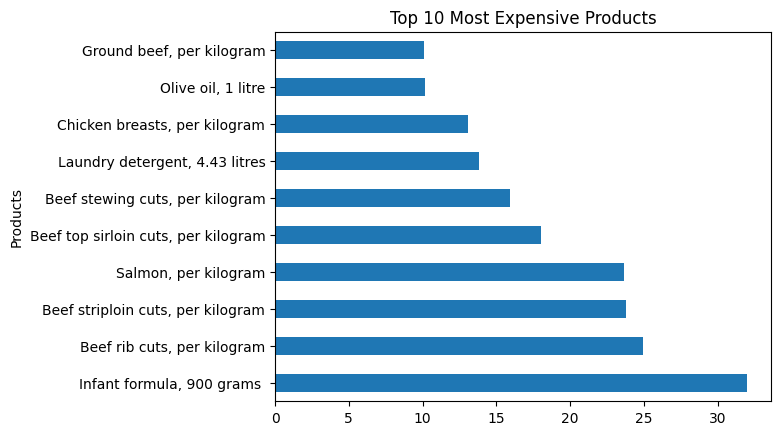

In [7]:
top_products = data.groupby('Products')['VALUE'].mean().sort_values(ascending=False).head(10)
top_products.plot(kind='barh')
plt.title('Top 10 Most Expensive Products')

<Axes: >

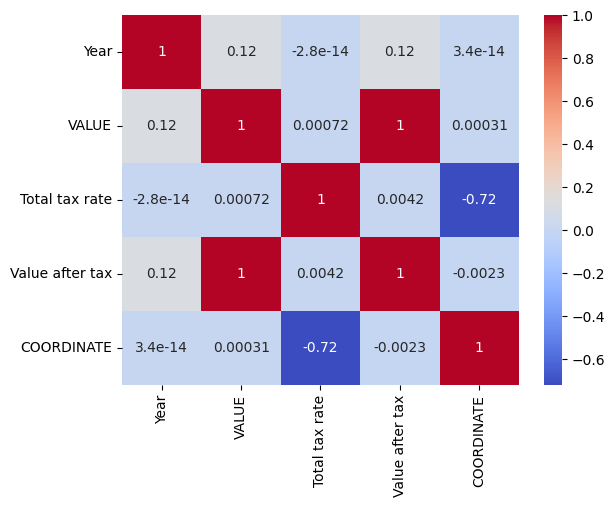

In [8]:
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='coolwarm')

In [9]:
for col in data.columns:
    le=LabelEncoder()
    data[col]=le.fit_transform(data[col])

In [10]:
x=data.drop(["Value after tax"],axis=1)
y=data["Value after tax"]

In [11]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [12]:
ss=StandardScaler()
x_train=ss.fit_transform(x_train)
x_test=ss.transform(x_test)

In [13]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Elastic Net Regression": ElasticNet(),
    "Bayesian Ridge Regression": BayesianRidge(),
    "Decision Tree Regression": DecisionTreeRegressor()
}

In [14]:
param_grid = {
    "Linear Regression": {}, 
    "Ridge Regression": {"alpha": [0.1, 1.0, 10.0, 100.0]},
    "Lasso Regression": {"alpha": [0.0001, 0.001, 0.01, 0.1, 1]},
    "Elastic Net Regression": {
        "alpha": [0.0001, 0.001, 0.01, 0.1, 1],
        "l1_ratio": [0.1, 0.5, 0.7, 0.9, 1.0],
    },
    "Bayesian Ridge Regression": {"alpha_1": [1e-6, 1e-4, 1e-2, 1], "alpha_2": [1e-6, 1e-4, 1e-2, 1]},
    "Decision Tree Regression": {
        "max_depth": [3, 5, 10, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
}
}

In [15]:
def tune_model(model, params, x_train, y_train):
    grid_search = GridSearchCV(model, param_grid=params, cv=5, scoring="r2", n_jobs=-1)
    grid_search.fit(x_train, y_train)
    return grid_search.best_estimator_

In [16]:
best_models = {}
for model_name, model in models.items():
    print(f"Tuning {model_name}...")
    best_models[model_name] = tune_model(model, param_grid[model_name], x_train, y_train)

Tuning Linear Regression...
Tuning Ridge Regression...
Tuning Lasso Regression...
Tuning Elastic Net Regression...
Tuning Bayesian Ridge Regression...
Tuning Decision Tree Regression...


In [17]:
model_scores = {}
for model_name, model in best_models.items():
    y_pred = model.predict(x_test)
    r2 = r2_score(y_test, y_pred)
    model_scores[model_name] = r2  # Store R² Score

    print(f"\n📊 {model_name} Performance:")
    print(f"R² Score: {r2*100:.4f}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
    print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.4f}")


📊 Linear Regression Performance:
R² Score: 99.9250
MAE: 5.5144
RMSE: 13.6842

📊 Ridge Regression Performance:
R² Score: 99.9250
MAE: 5.5142
RMSE: 13.6842

📊 Lasso Regression Performance:
R² Score: 99.9250
MAE: 5.5127
RMSE: 13.6842

📊 Elastic Net Regression Performance:
R² Score: 99.9250
MAE: 5.5127
RMSE: 13.6842

📊 Bayesian Ridge Regression Performance:
R² Score: 99.9250
MAE: 5.5144
RMSE: 13.6842

📊 Decision Tree Regression Performance:
R² Score: 99.9997
MAE: 0.0982
RMSE: 0.9030


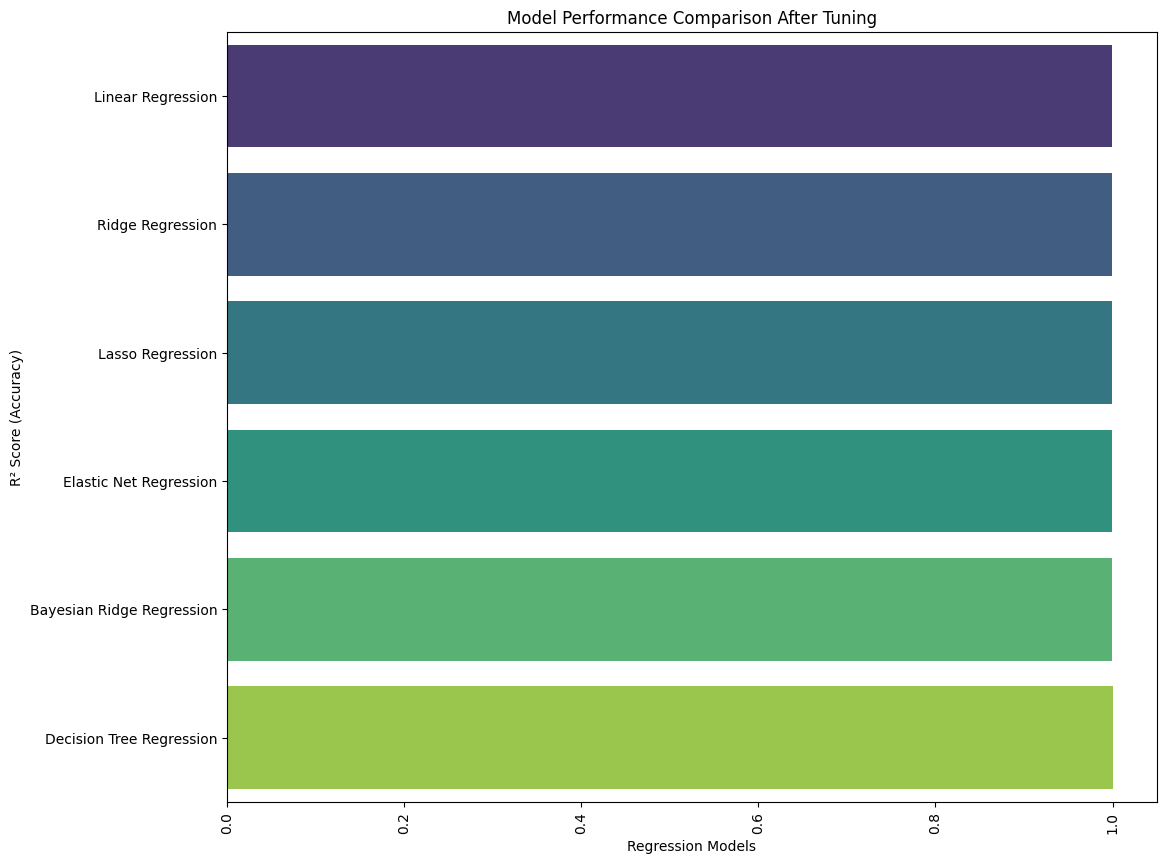

In [18]:
scores_df = pd.DataFrame(list(model_scores.items()), columns=["Model", "R² Score"])
plt.figure(figsize=(12, 10))
sns.barplot(y="Model", x="R² Score", data=scores_df, palette="viridis")
plt.xlabel("Regression Models")
plt.ylabel("R² Score (Accuracy)")
plt.title("Model Performance Comparison After Tuning")
plt.xticks(rotation=90)
plt.show()